# DIP A-4 2019040

## Q1 Restore Degraded Image

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:
path = "/home/hardeekh/Desktop/IIIT/Semester 5 (Monsoon 2021)/DIP/A-4/"

noise = cv2.imread(path+"noiseIm.jpg",0)
clean = cv2.imread(path+"x5.bmp",0)

In [3]:
def PSNR(given, restored):
    
    c = 0
    if given.shape[0]*given.shape[1] == 0:
        c = 1e-5
        
    mse = np.sum(np.square(given-restored)) / (given.shape[0]*given.shape[1]) + c
    psnr = 10*np.log10(255**2/mse)
    return psnr
    
def pad_img(image, new_size):
    
    one_side_pad = (new_size-image.shape[0])
    new_image = cv2.copyMakeBorder(image,0,one_side_pad,0,one_side_pad,cv2.BORDER_CONSTANT,None,value=0)
    return new_image

## box filter
n = 11
h = np.ones((n,n))/n**2

## laplacian
l = np.array([[0, -1, 0], [-1, 4, -1], [0, -1, 0]])

img=noise
new_size = img.shape[0]+11-1

## padding
padded_h = pad_img(h,new_size)
padded_l = pad_img(l,new_size)
padded_img = pad_img(img,new_size)

## calculate DFT
h_dft = np.fft.fft2(padded_h)
l_dft = np.fft.fft2(padded_l)
img_dft = np.fft.fft2(padded_img)

lambdas = [0.00,0.25,0.50,0.75,1.00]

outputs = []
psnr_val = []
filters = []

for lembda in lambdas:
    
    ## apply formula from L20 -> H'*G/(H^2+lambda*L^2)
    filt = np.conj(h_dft)/(np.absolute(h_dft)**2 + lembda*np.absolute(l_dft)**2)
    denoise = img_dft*filt
    
    result = np.real(np.fft.ifft2(denoise))[:256,:256]
    psnr_val.append(PSNR(clean,result))
    outputs.append(result)
    filters.append(np.fft.fftshift(filt))

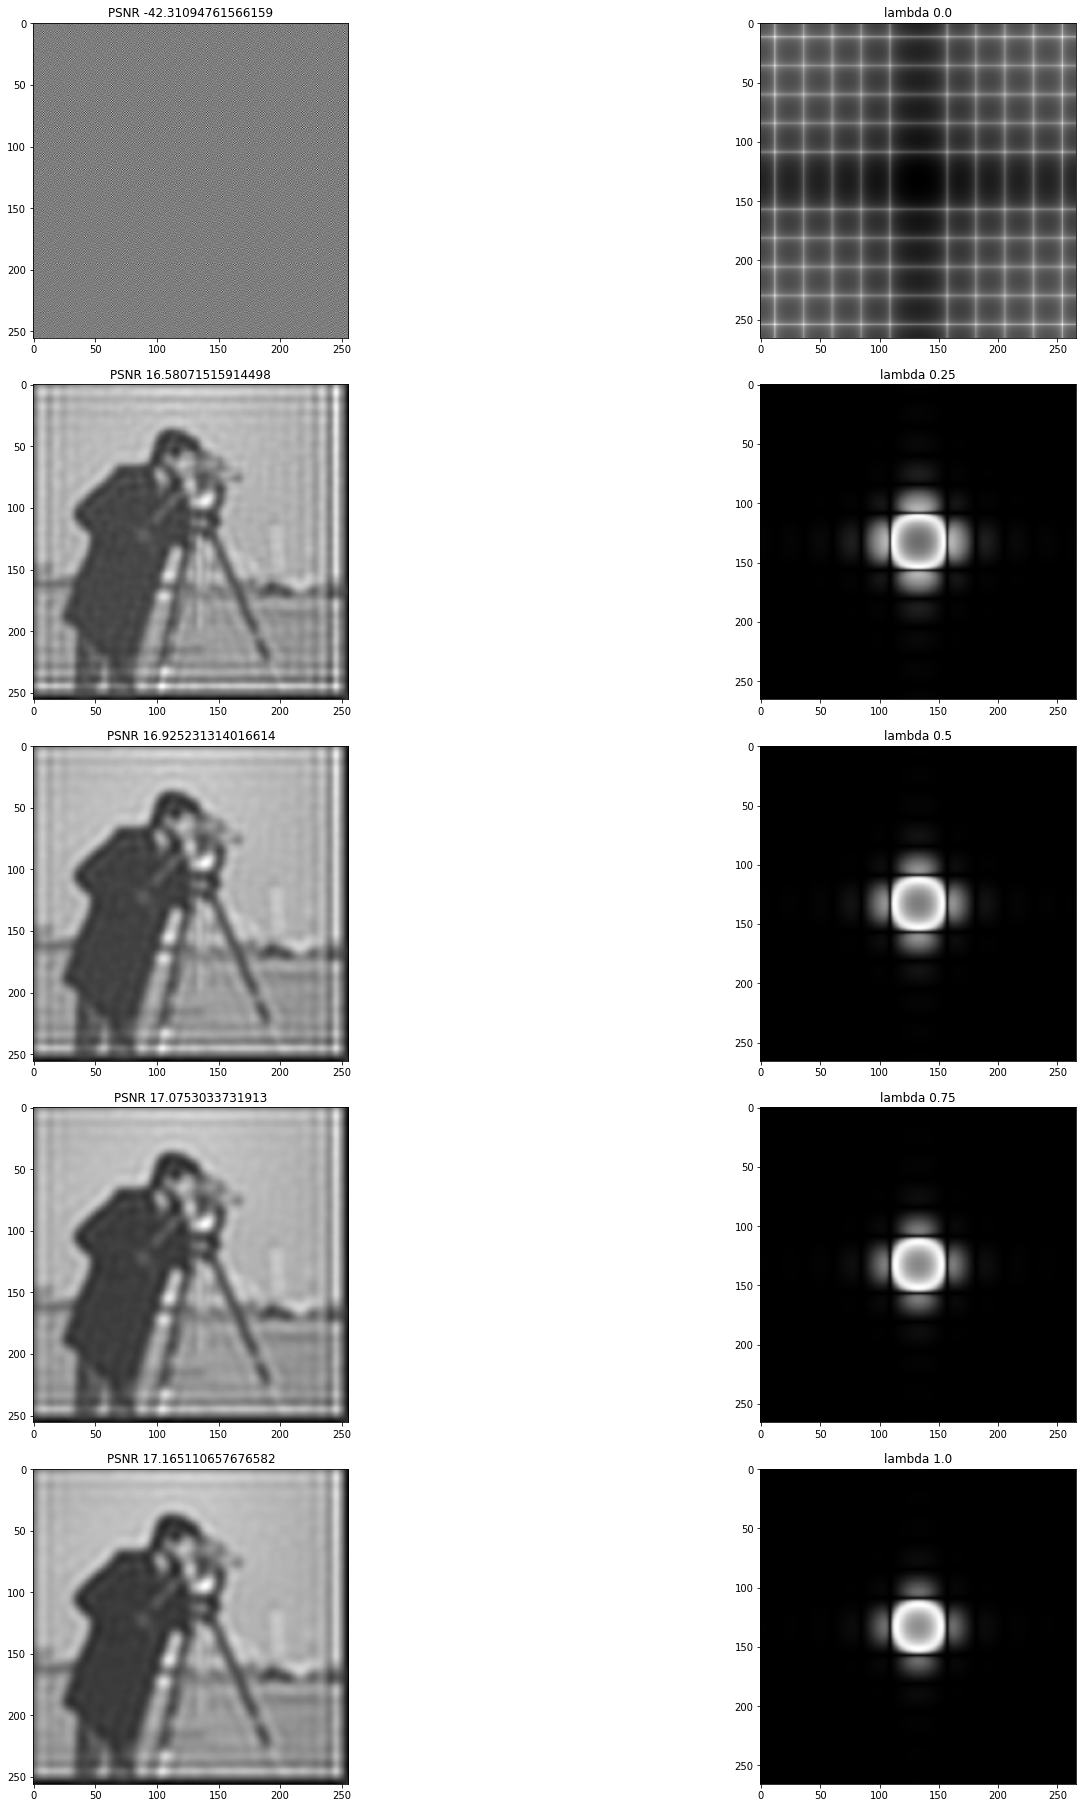

In [4]:
## display each filter and image one by one

label1 = ["PSNR "+str(i) for i in psnr_val]
label2 = ["lambda "+str(lembda) for lembda in lambdas]

plt.rcParams['figure.constrained_layout.use'] = True
f,ax = plt.subplots(5,2,figsize=(20,25))
ax[0,0].imshow(outputs[0],cmap="gray")
ax[0,0].set_title(label1[0])
ax[0,1].imshow(20*np.log(1+(np.abs(filters[0]))),cmap="gray")
ax[0,1].set_title(label2[0])

ax[1,0].imshow(outputs[1],cmap="gray")
ax[1,0].set_title(label1[1])
ax[1,1].imshow(20*np.log(1+(np.abs(filters[1]))),cmap="gray")
ax[1,1].set_title(label2[1])

ax[2,0].imshow(outputs[2],cmap="gray")
ax[2,0].set_title(label1[2])
ax[2,1].imshow(20*np.log(1+(np.abs(filters[2]))),cmap="gray")
ax[2,1].set_title(label2[2])

ax[3,0].imshow(outputs[3],cmap="gray")
ax[3,0].set_title(label1[3])
ax[3,1].imshow(20*np.log(1+(np.abs(filters[3]))),cmap="gray")
ax[3,1].set_title(label2[3])

ax[4,0].imshow(outputs[4],cmap="gray")
ax[4,0].set_title(label1[4])
ax[4,1].imshow(20*np.log(1+(np.abs(filters[4]))),cmap="gray")
ax[4,1].set_title(label2[4])
plt.show()

## Q3 Histogram Equalization

In [5]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def norm_hist(in_img):
    
    m,n = in_img.shape
    flat = in_img.flatten()
   
    freq_dict = {}
    
    for pixel in flat:
        
        if pixel not in freq_dict:
            freq_dict[pixel]=1
        else:
            freq_dict[pixel]+=1
     
    for key in freq_dict:
        freq_dict[key]=freq_dict[key]/(m*n)
        
    return freq_dict

def get_cdf(norm_hist):
    
    freq_dict = {}
    
    sorted_keys = sorted(norm_hist.keys())
    
    freq_dict[sorted_keys[0]]=norm_hist[sorted_keys[0]]
    
    for i in range(1,len(sorted_keys)):
        freq_dict[sorted_keys[i]]=freq_dict[sorted_keys[i-1]]+norm_hist[sorted_keys[i]]
     
    return freq_dict
  
def hist_eq(in_img):
    
    in_h = norm_hist(in_img)
    in_H = get_cdf(in_h)
    
    out_img = np.zeros(in_img.shape)
    
    for key in in_H:
        out_img[in_img==key]=in_H[key]
        
    out_h = norm_hist(out_img*255)
    out_H = get_cdf(out_h)
    
    return in_img, in_h, in_H, out_img, out_h, out_H
  
def plot_hist(hist, title, c):
    
    plt.title(title)
    plt.plot(hist.keys(),hist.values(), color=c)
    plt.bar(np.arange(len(hist)), hist, color=c)
    plt.xlabel("Pixel values")
    plt.ylabel("Fraction of Pixels")
    plt.show()
    
def plot_cdf(cdf, title):
    
    plt.title(title)
    plt.plot(cdf.keys(), cdf.values(), color='b')
    plt.xlabel("Pixel values")
    plt.ylabel("Fraction of Pixels")
    plt.show()
    

In [6]:
from skimage.color import hsv2rgb, rgb2hsv
from skimage.exposure import equalize_hist

path = "/home/hardeekh/Desktop/IIIT/Semester 5 (Monsoon 2021)/DIP/A-4/"
name="Fig0646(a)(lenna_original_RGB).tif"
img = cv2.imread(path+name,1)

## scale
img = img/255

In [7]:
def rgb_to_hsi(img):
  
    R = img[:,:,0]
    G = img[:,:,1]
    B = img[:,:,2]
    
    ## Hue
    num = 0.5*((R-G)+(R-B))
    den = np.sqrt((R-G)**2 + (R-B)*(G-B))
    
    theta = np.arccos(np.divide(num,den,out=np.zeros_like(num),where=den!=0))
    
    H = theta*180/np.pi
    H[B>G] = 360-H[B>G]
    
    ## Saturation
    num = 3*np.minimum(np.minimum(R,G),B)
    den = R+G+B
    S = 1 - np.divide(num,den,out=np.ones_like(num),where=den!=0)
    
    ## Intensity
    I = (R+G+B)/3
    
    return cv2.merge((H,255*S,255*I)) ## [0,360], [0,255], [0,255]

def t1(I,S):
    return I*(1-S)

def t2(I,S,H):
    
    return I*(1+np.divide(S*np.cos(H*np.pi/180),np.cos((60-H)*np.pi/180)))

def t3(I,t1,t2):
    
    return 3*I - (t1+t2)

def hsi_to_rgb(img):
    
    H = img[:,:,0]
    S = img[:,:,1]/255
    I = img[:,:,2]/255
    
    R,G,B = np.zeros(H.shape), np.zeros(S.shape), np.zeros(I.shape)
    
    ## make cases based on value of H
    
    # for 0 <= H < 120
    B[(0<=H)&(H<120)] = t1(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)])
    R[(0<=H)&(H<120)] = t2(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)], H[(0<=H)&(H<120)])
    G[(0<=H)&(H<120)] = t3(I[(0<=H)&(H<120)], R[(0<=H)&(H<120)], B[(0<=H)&(H<120)])

    # for 120 <= H < 240
    H = H-120
    R[(0<=H)&(H<120)] = t1(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)])
    G[(0<=H)&(H<120)] = t2(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)], H[(0<=H)&(H<120)])
    B[(0<=H)&(H<120)] = t3(I[(0<=H)&(H<120)], R[(0<=H)&(H<120)], G[(0<=H)&(H<120)])

    # for 240 <= H < 360
    H = H-120
    G[(0<=H)&(H<120)] = t1(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)])
    B[(0<=H)&(H<120)] = t2(I[(0<=H)&(H<120)], S[(0<=H)&(H<120)], H[(0<=H)&(H<120)])
    R[(0<=H)&(H<120)] = t3(I[(0<=H)&(H<120)], G[(0<=H)&(H<120)], B[(0<=H)&(H<120)])

    return cv2.merge(((255*R) , (255*G) , (255*B)) ) ## [0,255]

In [8]:
## convert image to hsi
hsi = rgb_to_hsi(img)

## histogram equalization of intensity
in_I, in_h, in_H, out_I, out_h, out_H = hist_eq((hsi[:,:,2]))

## construct the new HSI
hsi_eq = cv2.merge((hsi[:,:,0],hsi[:,:,1],out_I))

## convert HSI to RGB
rgb_eq = hsi_to_rgb(hsi_eq)

rgb_rest = hsi_to_rgb(hsi)

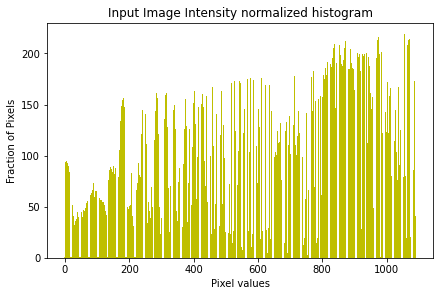

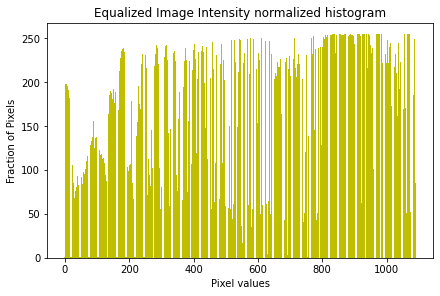

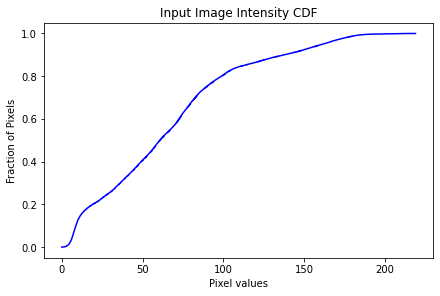

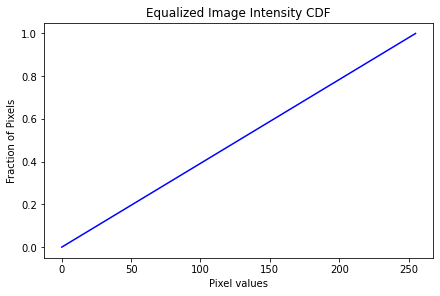

In [9]:
## plotting
plot_hist(in_h,"Input Image Intensity normalized histogram","y")
plot_hist(out_h,"Equalized Image Intensity normalized histogram","y")
plot_cdf(in_H,"Input Image Intensity CDF")
plot_cdf(out_H,"Equalized Image Intensity CDF")

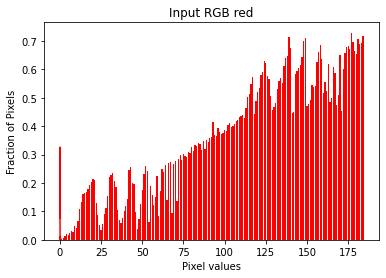

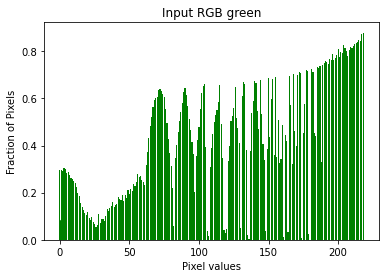

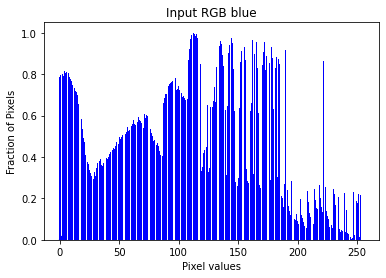

In [37]:
## input and output rgb histogram plots

r = norm_hist(img[:,:,0])
g = norm_hist(img[:,:,1])
b = norm_hist(img[:,:,2])

plot_hist(r,"Input RGB red","r")
plot_hist(g,"Input RGB green","g")
plot_hist(b,"Input RGB blue","b")

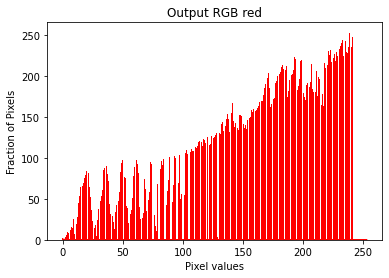

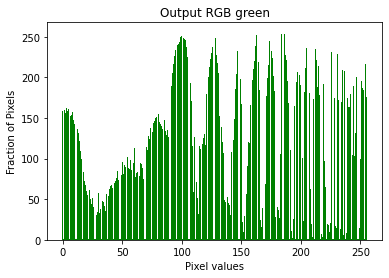

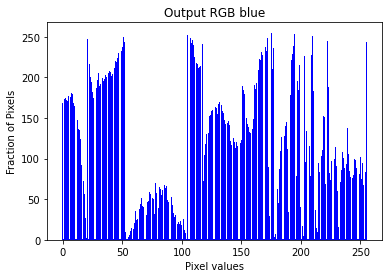

In [38]:
r = norm_hist(np.uint8(255*rgb_eq[:,:,0]))
g = norm_hist(np.uint8(255*rgb_eq[:,:,1]))
b = norm_hist(np.uint8(255*rgb_eq[:,:,2]))

plot_hist(r,"Output RGB red","r")
plot_hist(g,"Output RGB green","g")
plot_hist(b,"Output RGB blue","b")

In [69]:
cv2.imshow("input",img)
cv2.imshow("hsi",np.uint8(hsi))
cv2.imshow("hsi_eq",np.uint8(hsi_eq))
cv2.imshow("output_eq",(rgb_eq))
cv2.imshow("output_original",np.uint8(rgb_rest))
cv2.waitKey(0)
cv2.destroyAllWindows()